In [1]:
import numpy as np
import os, sys, subprocess
import pandas as pd
from astropy.io import fits
from astropy.coordinates import SkyCoord
from astropy import units as u
from astropy.wcs import WCS
from astropy.nddata.utils import Cutout2D
from astropy.cosmology import Planck15 as cosmo
from matplotlib import pyplot as plt
from matplotlib import font_manager
import config

from pathlib import Path
home = str(Path.home())
original_path = os.getcwd()
MainPath = home+'/sed_fitting/'
%matplotlib inline

In [2]:
def load_cutout(id_source, telescope, filtername, kind):
    file_name = 'Galaxies/{0}/{1}_{2}_{3}.fits'.format(id_source, telescope, filtername, kind)
    cutout = FitsUtils(file_name, filtername, kind)
    return cutout
    
class FitsUtils:
    def __init__(self, fits_path, filtername, kind):
        import numpy as np
        from astropy.io import fits
        from astropy.wcs import WCS
        self.fits_path = fits_path
        self.filtername = filtername
        self.kind = kind
        self.fitsfile = fits.open(self.fits_path)
        if filtername == 'VLA' :self.signal = fits.getdata(self.fits_path)
        else: self.signal = fits.getdata(self.fits_path)/10
        self.unit = 'nJy'
        if filtername == 'VLA':
            self.signal = self.signal[0, 0]
            self.hdr = fits.getheader(self.fits_path)
            self.wcs = WCS(self.hdr)
            self.wcs  = self.wcs.dropaxis(3)
            self.wcs  = self.wcs.dropaxis(2)
        else:
            self.hdr = self.fitsfile[1].header
            self.wcs = WCS(self.hdr)
        try: self.pixel_scale = (self.hdr['PC2_2']*u.deg).to('arcsec')
        except: pass
        return
    
    def extract_ellipse(self, galaxy_coord, radius, axial_ratio = 1.0, pos_angle = 0):
        # Mask the image...
        image_masked = self.signal.copy()
        image_masked[ np.where( image_masked>-100 ) ] = np.nan
        # ...and restore original pixels in elliptical mask
        centre_x, centre_y = galaxy_coord.to_pixel(self.wcs)
        ellipse_mask = EllipseMask(self.signal, radius/self.pixel_scale, axial_ratio, pos_angle, centre_x, centre_y)
        image_masked[ np.where( ellipse_mask==1 ) ] = self.signal[ np.where( ellipse_mask==1 ) ]
        self.signal_ellipse = image_masked
        return
    
    def apply_masked_clipping(self, galaxy_coord, radius, axial_ratio = 1.0, pos_angle = 0, cutoff_sigma = 3):
        # Sigma clip the image
        clip_value = PS.SigmaClip(self.signal, tolerance=0.01, sigma_thresh = 3, median=True)
        noise_value, field_value = clip_value[0], clip_value[1]
        cutoff = field_value + (cutoff_sigma * noise_value)
        # Mask the image...
        image_masked = self.signal.copy()
        # ...removing image pixels identified as having high SNR...
        image_masked[ np.where( image_masked>cutoff ) ] = 0
        ## ...and image pixels equal to zero, because Spitzer sucks
        #image_masked[ np.where( image_masked==0 ) ] = np.nan
        # ...and restore original pixels in elliptical mask
        centre_x, centre_y = galaxy_coord.to_pixel(self.wcs)
        ellipse_mask = EllipseMask(self.signal, radius/self.pixel_scale, axial_ratio, pos_angle, centre_x, centre_y)
        image_masked[ np.where( ellipse_mask==1 ) ] = self.signal[ np.where( ellipse_mask==1 ) ]
        self.signal_masked_clipping = image_masked
        return

    def apply_ellipse_masking(self, galaxy_coord, radius, axial_ratio = 1.0, pos_angle = 0, mask = False):
        # Mask the image around ellipse...
        image_masked = self.signal.copy()
        if mask:
            image_masked[mask] = np.nan
            self.signal_masked = image_masked
            return
        centre_x, centre_y = galaxy_coord.to_pixel(self.wcs)
        ellipse_mask = EllipseMask(self.signal, radius/self.pixel_scale, axial_ratio, pos_angle, centre_x, centre_y)
        image_masked[ np.where( ellipse_mask==0 ) ] = np.nan
        self.signal_masked = image_masked
        return
    
    def apply_smart_masking(self, galaxy_coord, radius, axial_ratio = 1.0, pos_angle = 0, cutoff_sigma = 3):
        # Mask the image...
        image_masked = self.signal.copy()
        centre_x, centre_y = galaxy_coord.to_pixel(self.wcs)
        ellipse_mask = EllipseMask(self.signal, radius/self.pixel_scale, axial_ratio, pos_angle, centre_x, centre_y)
        image_masked[ np.where( ellipse_mask==0 ) ] = np.nan
        # Sigma clip the masked image
        clip_value = PS.SigmaClip(image_masked, tolerance=0.01, sigma_thresh = 3, median=True)
        noise_value, field_value = clip_value[0], clip_value[1]
        cutoff = field_value + (cutoff_sigma * noise_value)
        # ...removing image pixels identified as having low SNR...
        image_masked[ np.where( image_masked<cutoff ) ] = np.nan
        self.signal_masked = image_masked
        return

In [3]:
filters = ['f435w', 'f475w', 'f606w', 'f814w', 'f090w', \
            'f115w', 'f150w', 'f200w', 'f277w', 'f356w', \
            'f410m', 'f444w', 'f770w', 'f1800w']

gal_id = 'test_new'
lister = [(p.split('_')[1], p.split('_')[0]) for p in os.listdir('Galaxies/{}'. format(gal_id)) if not p.startswith('.')]
df_bundle = pd.DataFrame(lister, columns = ['Filter', 'Telescope'])
df_bundle['Wvl'] = [config.band_wvl_association[f] for f in df_bundle['Filter']]
df_bundle = df_bundle.sort_values(by='Wvl').reset_index(drop = True)

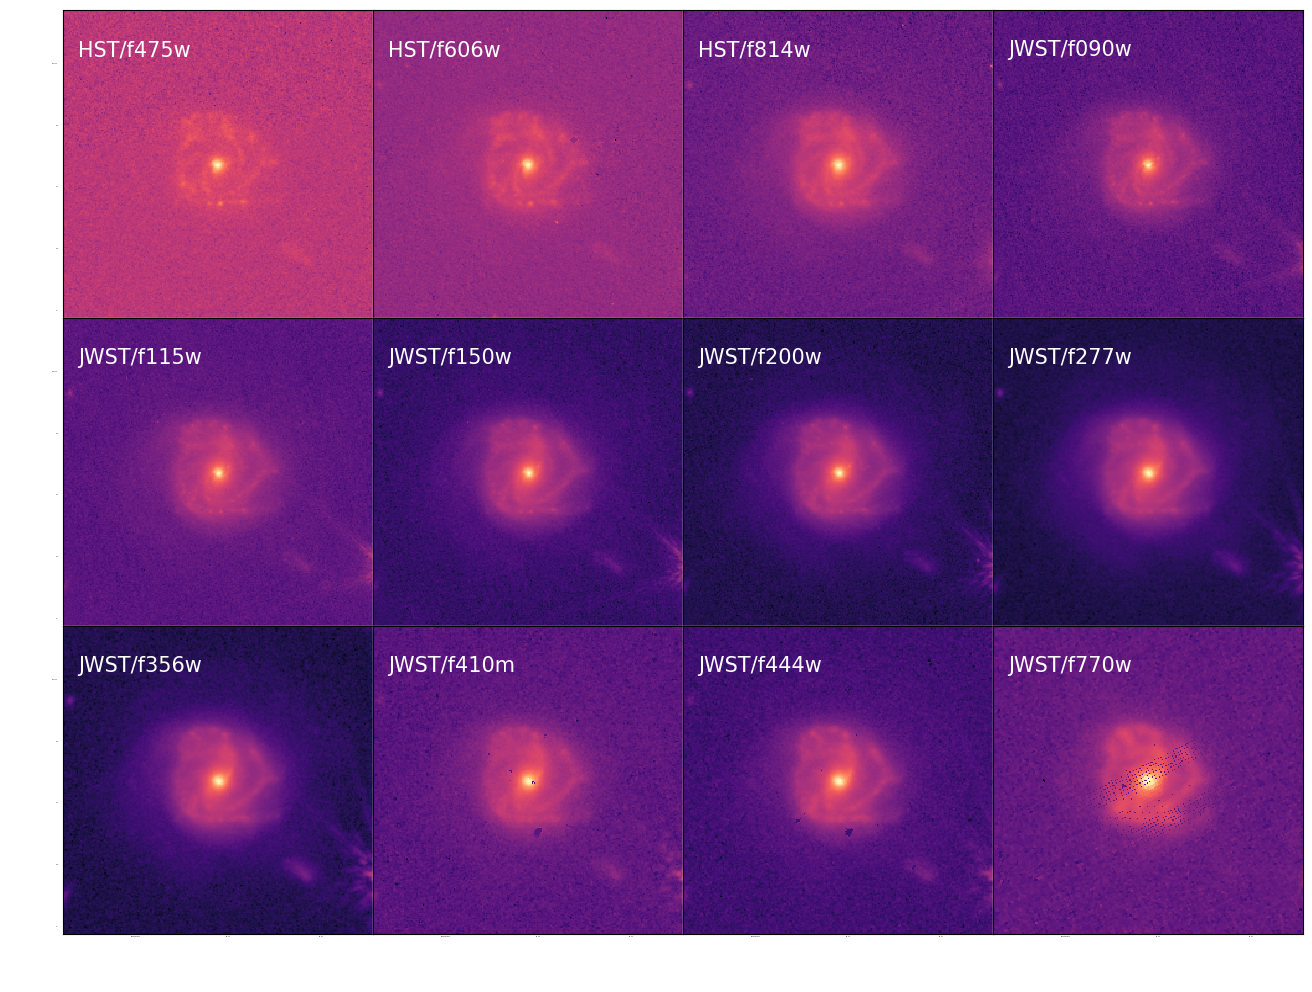

In [4]:
from matplotlib import cm
from astropy.visualization import (MinMaxInterval, LogStretch, ImageNormalize)
import warnings
warnings.filterwarnings("ignore")

color_dict = {'orange': '#ffab40', 'blue': '#4285f4ff', 'purple': '#a64d79', 'turchese': '#0097a7'}

# Fig
fig = plt.figure(figsize=(16, 16))
for i, map_row in df_bundle.iterrows():
    cutout = load_cutout(gal_id, map_row.Telescope, map_row.Filter, 'sci')
    ax = plt.subplot(4, 4, i+1, projection = cutout.wcs)
    vmin, vmax = cutout.signal.min(), cutout.signal.max()
    minfac, maxfac = 1, 1
    norm = ImageNormalize(cutout.signal, interval=MinMaxInterval(), stretch=LogStretch(), vmin = cutout.signal.min()/minfac, vmax = cutout.signal.max()*maxfac)
    ax.imshow(cutout.signal, origin = 'lower', interpolation = 'nearest', cmap = cm.magma, norm = norm, aspect = "auto")
    ax.coords['ra'].set_axislabel(' ', fontsize = 20), ax.coords['dec'].set_axislabel(' ', fontsize = 20)
    ax.coords['ra'].set_ticklabel(size=0), ax.coords['dec'].set_ticklabel(size=0)
    ax.coords['ra'].set_ticks(size = 0), ax.coords['dec'].set_ticks(size = 0)
    ax.coords['ra'].display_minor_ticks(False), ax.coords['dec'].display_minor_ticks(False)
    ax.text(0.05, 0.85, '{0}/{1}'.format(map_row.Telescope, map_row.Filter), size = 15, color = 'w', transform = ax.transAxes)

fig.subplots_adjust(wspace = 0.0, hspace = 0.0)
#fig.savefig('{}.pdf'.format(src_row['Idx_RSND']), bbox_inches = 'tight')

---